# Identifying tetris blocks with a equivariant neural network

Similar to last weeks task, we will again identify tetri block. However, this time we will represent them by the center points of their blocks. Note, that with just a graph neural network, it is not possible to distinguish between some of these blocks, as the resulting graphs are isomorph. This will make it necessary to use an equivariant neural network.

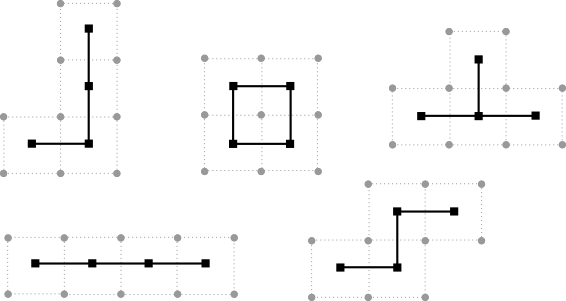

***Note:*** A major challenge when working with equivariant tensors is to keep track of the indexing. Therefore, we recommend that you first read through this excercise to get an overview, and then go through the given code to understand the sparse indexing. This is crucial to implement the SO(3) convolution in the tasks.

In [21]:
from typing import List, Callable, Tuple

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

## Creating the dataset

First, we define the 2d positions of the nodes of the mesh. Below is some modified code from the last excercise, that takes care of this:

In [22]:
lblock = torch.tensor([[0.,0.,0.], [1.,0.,0.], [1.,1.,0.], [1.,2.,0.]])
square = torch.tensor([[0.,0.,0.], [1.,0.,0.], [0.,1.,0.], [1.,1.,0.]])
line = torch.tensor([[0.,0.,0.], [1.,0.,0.], [2.,0.,0.], [3.,0.,0.]])
step = torch.tensor([[0.,0.,0.], [1.,0.,0.], [1.,1.,0.], [2.,1.,0.]])
tblock = torch.tensor([[0.,0.,0.], [1.,0.,0.], [2.,0.,0.], [1.,1.,0.]])
tetris_blocks = [lblock, square, line, step, tblock]

def compute_edges(points:torch.FloatTensor, cutoff:float=1.) -> torch.LongTensor:
    """
    This function computes the edges of graph given an array of nodes with 2d coordinates.
    The graph will we created by connecting all nodes with an euclidean distance smaller or equal
    than the provided cutoff.

    Args:
    - points: tensor of coordinates with shape (num_nodes x 2)
    - cutoff: cutoff distance to determine whether two points are connected in the graph.

    Returns:
    - edges: tensor of shape [num_edges x 2] where each row corresponds to the indices of the 
      connected nodes (incoming, outgoing)

    """
    distances = torch.sqrt(torch.sum((points[:,None, :] - points[None,:,:])**2, dim=-1))
    adjacency_matrix = (distances <= cutoff) * (distances > 0.)
    edges = torch.nonzero(adjacency_matrix)
    return edges

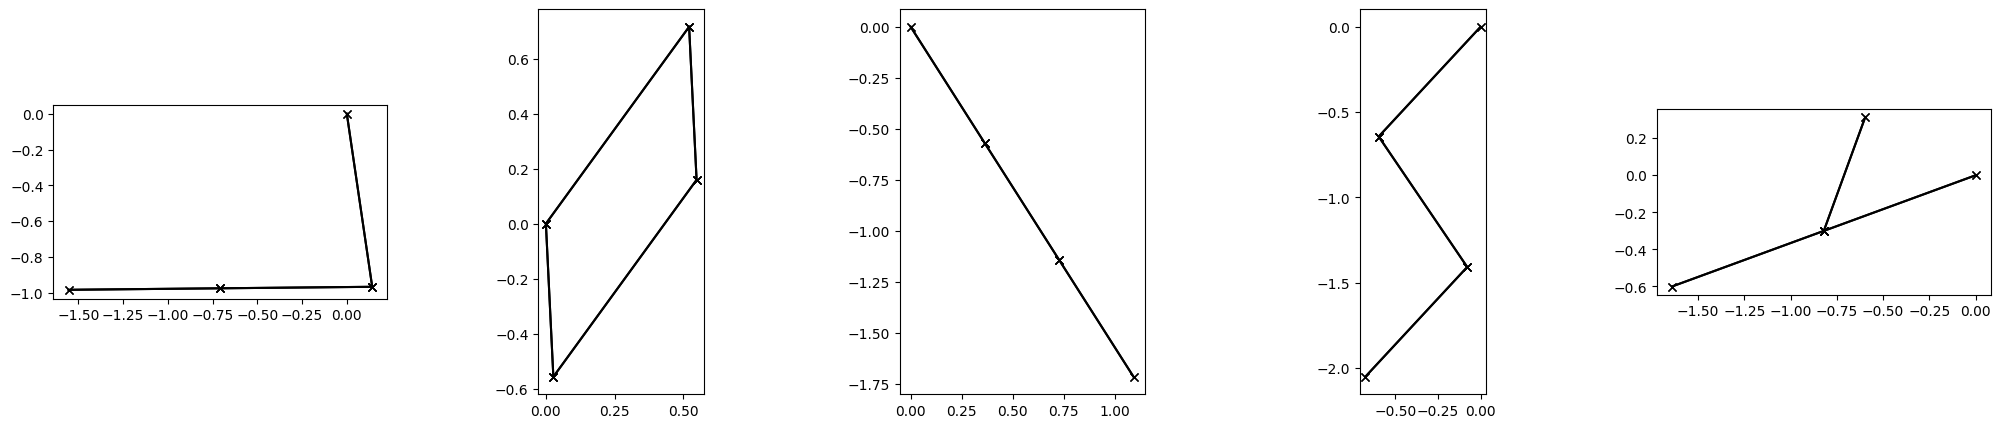

In [23]:
def generate_random_rotation(batch_size, device, dtype, deflection=1.0):
    theta = torch.rand(batch_size, 1, device=device, dtype=dtype)
    theta *= 2.0 * math.pi * deflection
    phi = torch.rand(batch_size, 1, device=device, dtype=dtype) * 2.0 * math.pi
    z = torch.rand(batch_size, 1, device=device, dtype=dtype)
    z *= 2.0 * deflection
    r = torch.sqrt(z)
    v = torch.cat([torch.sin(phi) * r, torch.cos(phi) * r, torch.sqrt(2.0 - z)], dim=1)
    vv = torch.einsum("bi,bj->bij", v, v)
    H = vv - torch.eye(3, device=vv.device)[None]
    stheta = torch.sin(theta)
    ctheta = torch.cos(theta)
    zeros = torch.zeros_like(stheta)
    ones = torch.ones_like(stheta)
    R = torch.cat(
        [ctheta, stheta, zeros, -stheta, ctheta, zeros, zeros, zeros, ones], dim=1
    )
    R = torch.reshape(R, (batch_size, 3, 3))
    R = torch.bmm(H, R)
    return R


def create_dataset(shuffle:bool=False, rotate=False, cutoff:float=1.1):
    tetris_edges = []
    tetris_points = []
    for points in tetris_blocks:
        if shuffle:
            sort_idx = torch.randperm(points.shape[0])
            points = points[sort_idx]
        if rotate:
            R = generate_random_rotation(1, device=points.device, dtype=points.dtype)[0]
            points = torch.mm(points, R)
        tetris_points.append(points)

        edges = compute_edges(points, cutoff)
        tetris_edges.append(edges)
    return tetris_points, tetris_edges

tetris_points, tetris_edges = create_dataset(shuffle=False, rotate=True)

plt.figure(figsize=(25, 5))
for i, graph in enumerate(zip(tetris_points, tetris_edges)):
    block, edges = graph
    plt.subplot(1, 5, i+1)
    X = torch.vstack([block[edges[:,0],0], block[edges[:,1], 0]])
    Y = torch.vstack([block[edges[:,0],1], block[edges[:,1], 1]])
    plt.plot(X, Y, c='k', marker='x')
    plt.gca().set_aspect('equal')

plt.show()

In [24]:
def build_batch(points_list:List[torch.Tensor], edges_list:List[torch.Tensor]) -> Tuple[torch.LongTensor, torch.LongTensor, torch.LongTensor]:
    num_nodes = torch.tensor([torch.max(edges)+1 for edges in edges_list])
    classes = torch.arange(len(tetris_edges), dtype=torch.long)
    block_idx = torch.repeat_interleave(classes, num_nodes)

    # convert node indices to global batch indices
    node_offsets = torch.cumsum(torch.cat([torch.zeros((1,), dtype=torch.long), num_nodes]), 0)
    global_edges_list = [edges + node_offsets[i] for i, edges in enumerate(edges_list)]
    batched_node_labels = torch.ones((torch.sum(num_nodes), 1))
    batched_positions = torch.vstack(points_list)
    batched_edges = torch.vstack(global_edges_list)
    return batched_node_labels, batched_positions, batched_edges, block_idx, classes
    
batch = build_batch(tetris_points, tetris_edges)

print(f'batched_node_labels [first 10 entrie]: {batch[0][:10]}')
print(f'batched_positions [first 10 entrie]: {batch[1][:10]}')
print(f'batched_edges [first 10 entrie]: {batch[2][:10]}')
print(f'block_idx: {batch[3]}')
print(f'classes: {batch[4]}')

batched_node_labels [first 10 entrie]: tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])
batched_positions [first 10 entrie]: tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.1419, -0.9669, -0.2122],
        [-0.7065, -0.9753, -0.7414],
        [-1.5549, -0.9836, -1.2707],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.5211,  0.7165,  0.4637],
        [ 0.0272, -0.5569,  0.8301],
        [ 0.5483,  0.1596,  1.2938],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.3639, -0.5715, -0.7355]])
batched_edges [first 10 entrie]: tensor([[0, 1],
        [1, 0],
        [1, 2],
        [2, 1],
        [2, 3],
        [3, 2],
        [4, 5],
        [4, 6],
        [5, 4],
        [5, 7]])
block_idx: tensor([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4])
classes: tensor([0, 1, 2, 3, 4])


# Helper functions

Below you find the `scatter_add` function from last week's exercise, as well as spherical harmonics and Clebsch-Gordan coefficients. Implementing these is quite tedious, so we have prepared functions for you to use in the tasks below.


In [25]:
def scatter_add(
    x: torch.Tensor, idx: torch.Tensor, dim_size: int, dim: int = 0
) -> torch.Tensor:
    """
    Sum over given indices as described above.

    Args:
    - x: input tensor
    - idx: index tensor
    - dim: dimension along which is summed
    - dim_size: size of the dimension along which is summed in the output tensor

    Returns:
    - summed_x: tensor with shape: x.shape[:dim] + (dim_size,) + x.shape[dim+1:]
    """
    shape = list(x.shape)
    shape[dim] = dim_size
    tmp = torch.zeros(shape, dtype=x.dtype, device=x.device)
    summed_x = tmp.index_add(dim, idx, x)
    return summed_x

## Real spherical harmonics

The [real spherical harmonics ](https://en.wikipedia.org/wiki/Spherical_harmonics#Real_forms) $Y_{lm}$ are basis functions for the irreducible representation of the SO(3)
group. They can be visualized as isosurfaces as shown here:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/6/62/Spherical_Harmonics.png/450px-Spherical_Harmonics.png)

The rows correspond to increasing angular momentum number $l \geq 0$ and the the colums run from $m \in [-l, l]$. That means for a given $l_\text{max}$ there exist $2 l_\text{max} + 1$ basis functions.

The following layer evaluates spherical harmonics at given directions (i.e. a tensor of shape [N x 3]) up to the specified $l_\text{max}$. The resulting tensor is of shape [N x ($2 l_\text{max} + 1$) where the order of the basis functions $Y_{l,m}$ is the same as in the picture: $Y_{0,0}$, $Y_{1,-1}$, $Y_{1,0}$, $Y_{1,1}$, $Y_{2,-2}$, , $Y_{2,-1}$, etc. Below we will refer to these combined indices as s=(l,m).



In [26]:
def binom(n: torch.Tensor, k: torch.Tensor) -> torch.Tensor:
    """Computes the binomial coefficients"""
    return torch.exp(
        torch.lgamma(n + 1) - torch.lgamma((n - k) + 1) - torch.lgamma(k + 1)
    )

class RealSphericalHarmonics(nn.Module):
    """
    Generates the real spherical harmonics for a batch of normalized vectors.

    Spherical harmonics are generated up to angular momentum `lmax` in dimension 1,
    according to the following order:
    - l=0, m=0
    - l=1, m=-1
    - l=1, m=0
    - l=1, m=1
    - l=2, m=-2
    - l=2, m=-1
    - etc.
    """

    def __init__(self, lmax: int, dtype=torch.float32):
        super().__init__()
        self.lmax = lmax

        (
            powers,
            zpow,
            cAm,
            cBm,
            cPi,
        ) = self.generate_Ylm_coefficients(lmax)
        self.register_buffer("powers", powers.to(dtype=dtype), False)
        self.register_buffer("zpow", zpow.to(dtype=dtype), False)
        self.register_buffer("cAm", cAm.to(dtype=dtype), False)
        self.register_buffer("cBm", cBm.to(dtype=dtype), False)
        self.register_buffer("cPi", cPi.to(dtype=dtype), False)

        ls = torch.arange(0, lmax + 1)
        nls = 2 * ls + 1
        self.lidx = torch.repeat_interleave(ls, nls)
        self.midx = torch.cat([torch.arange(-l, l + 1) for l in ls])
        self.register_buffer("flidx", self.lidx.to(dtype=dtype), False)

    def generate_Ylm_coefficients(self, lmax: int):
        # calculate Am/Bm coefficients
        m = torch.arange(1, lmax + 1, dtype=torch.float64)[:, None]
        p = torch.arange(0, lmax + 1, dtype=torch.float64)[None, :]
        mask = p <= m
        mCp = binom(m, p)
        cAm = mCp * torch.cos(0.5 * math.pi * (m - p))
        cBm = mCp * torch.sin(0.5 * math.pi * (m - p))
        cAm *= mask
        cBm *= mask
        powers = torch.stack([torch.broadcast_to(p, cAm.shape), m - p], dim=-1)
        powers *= mask[:, :, None]

        # calculate Pi coefficients
        l = torch.arange(0, lmax + 1, dtype=torch.float64)[:, None, None]
        m = torch.arange(0, lmax + 1, dtype=torch.float64)[None, :, None]
        k = torch.arange(0, lmax // 2 + 1, dtype=torch.float64)[None, None, :]
        cPi = torch.sqrt(torch.exp(torch.lgamma(l - m + 1) - torch.lgamma(l + m + 1)))
        cPi = cPi * (-1) ** k * 2 ** (-l) * binom(l, k) * binom(2 * l - 2 * k, l)
        cPi *= torch.exp(torch.lgamma(l - 2 * k + 1) - torch.lgamma(l - 2 * k - m + 1))
        zpow = l - 2 * k - m

        # masking of invalid entries
        cPi = torch.nan_to_num(cPi, 100.0)
        mask1 = k <= torch.floor((l - m) / 2)
        mask2 = l >= m
        mask = mask1 * mask2
        cPi *= mask
        zpow *= mask

        return powers, zpow, cAm, cBm, cPi

    def forward(self, directions: torch.Tensor):
        target_shape = [
            directions.shape[0],
            self.powers.shape[0],
            self.powers.shape[1],
            2,
        ]
        Rs = torch.broadcast_to(directions[:, None, None, :2], target_shape)
        pows = torch.broadcast_to(self.powers[None], target_shape)

        Rs = torch.where(pows == 0, torch.ones_like(Rs), Rs)

        temp = Rs**self.powers
        monomials_xy = torch.prod(temp, dim=-1)

        Am = torch.sum(monomials_xy * self.cAm[None], 2)
        Bm = torch.sum(monomials_xy * self.cBm[None], 2)
        ABm = torch.cat(
            [
                torch.flip(Bm, (1,)),
                math.sqrt(0.5) * torch.ones((Am.shape[0], 1), device=directions.device),
                Am,
            ],
            dim=1,
        )
        ABm = ABm[:, self.midx + self.lmax]

        target_shape = [
            directions.shape[0],
            self.zpow.shape[0],
            self.zpow.shape[1],
            self.zpow.shape[2],
        ]
        z = torch.broadcast_to(directions[:, 2, None, None, None], target_shape)
        zpows = torch.broadcast_to(self.zpow[None], target_shape)
        z = torch.where(zpows == 0, torch.ones_like(z), z)
        zk = z**zpows

        Pi = torch.sum(zk * self.cPi, dim=-1)  # batch x L x M
        Pi_lm = Pi[:, self.lidx, abs(self.midx)]
        sphharm = torch.sqrt((2 * self.flidx + 1) / (2 * math.pi)) * Pi_lm * ABm
        return sphharm

## Clebsch-Gordan coefficients

These are some functions to obtain the Clebsch-Gordan (CG) coefficients for the real spherical harmonics. The function `generate_clebsch_gordan` is used in the equivariant layers to precompute a tensor of the required CG coefficients.

The CG coefficients $C_{l_1 m_2 l_2 m_2}^{L M} = <l_1 m_2 l_2 m_2 | L M>$ tell us how irreps couple in a tensor product. We will use them compute the
product of two spherical harmonics ($Y_{l_1m_1}$, $Y_{l_2m_2}$) in terms of a third ($Y_{LM}$).
Most of the CG coeeficients are zero, which significantly reduces the required compute. Therefore, we only extract the nonzero ones together with the indices for getting the correct (l_1,m_1), (l_2,m_2)
from the inputs and summing to obtain the final (L,M).

In [27]:
import numpy as np
from sympy.physics.wigner import clebsch_gordan
from sympy import sympify


def sh_indices(lmax: int):
    """Build index arrays for spherical harmonics"""
    ls = np.arange(0, lmax + 1)
    nls = 2 * ls + 1
    lidx = np.repeat(ls, nls)
    midx = np.concatenate([torch.arange(-l, l + 1) for l in ls])
    return lidx, midx

def generate_csh_to_rsh(lmax: int) -> np.ndarray:
    """
    Generate transformation matrix to convert (complex) spherical harmonics to real form
    """
    lidx, midx = sh_indices(lmax)
    l1 = lidx[:, None]
    l2 = lidx[None, :]
    m1 = midx[:, None]
    m2 = midx[None, :]
    U = (
        1.0 * ((m1 == 0) * (m2 == 0))
        + (-1.0) ** abs(m1) / np.sqrt(2) * ((m1 == m2) * (m1 > 0))
        + 1.0 / np.sqrt(2) * ((m1 == -m2) * (m2 < 0))
        + -1.0j * (-1.0) ** abs(m1) / np.sqrt(2) * ((m1 == -m2) * (m1 < 0))
        + 1.0j / np.sqrt(2) * ((m1 == m2) * (m1 < 0))
    ) * (l1 == l2)
    return U

def generate_clebsch_gordan_csh(lmax: int) -> np.ndarray:
    """Generate standard Clebsch-Gordan coefficients for complex spherical harmonics"""
    ls = np.arange(0, lmax + 1)
    nls = 2 * ls + 1
    lidx = np.repeat(ls, nls)
    midx = np.concatenate([torch.arange(-l, l + 1) for l in ls])

    cg = np.zeros((lidx.shape[0], lidx.shape[0], lidx.shape[0]))
    for c1, (l1, m1) in enumerate(zip(lidx, midx)):
        for c2, (l2, m2) in enumerate(zip(lidx, midx)):
            for c3, (l3, m3) in enumerate(zip(lidx, midx)):
                if abs(l1 - l2) <= l3 <= min(l1 + l2, lmax) and m3 in {
                    m1 + m2,
                    m1 - m2,
                    m2 - m1,
                    -m1 - m2,
                }:
                    coeff = clebsch_gordan(*sympify((l1, l2, l3, m1, m2, m3)))
                    cg[c1, c2, c3] = float(coeff)
    return cg

def generate_clebsch_gordan(lmax: int, parity_mode: str = "mask") -> torch.Tensor:
    """
    Generate Clebsch-Gordan coefficients for real spherical harmonics
    """
    cg = generate_clebsch_gordan_csh(lmax)
    U = generate_csh_to_rsh(lmax)
    cg_rsh = np.einsum("ijk,mi,nj,ok->mno", cg, U, U, U.conj())

    lidx, _ = sh_indices(lmax)
    if parity_mode == "mask":
        parity = (-1.0) ** lidx
        pmask = parity[:, None, None] * parity[None, :, None] == parity[None, None, :]
        cg_rsh *= pmask
    elif parity_mode == "realize":
        lsum = lidx[:, None, None] + lidx[None, :, None] - lidx[None, None, :]
        cg_rsh *= 1.0j**lsum
    else:
        raise ValueError('Argument `parity_mode` has to be one of ["mask", "realize"]')

    # cast to real
    cg = cg_rsh.real.astype(np.float64)

    # extract nonzero CGs + indices
    cg = torch.from_numpy(cg)
    cg = cg.to(torch.float32)
    idx = torch.nonzero(cg)
    idx_l1m1, idx_l2m2, idx_LM = torch.split(idx, 1, dim=1)
    idx_l1m1, idx_l2m2, idx_LM = (
        idx_l1m1[:, 0],
        idx_l2m2[:, 0],
        idx_LM[:, 0],
    )
    cg = cg[idx_l1m1, idx_l2m2, idx_LM]
    return cg, idx_l1m1, idx_l2m2, idx_LM


# Equivariant layers

In the follwoing, your task is to implement the required components to build an SO(3) equivariant neural network using the functions described above. This will include:
- an equivariant non-linearity
- the radial filter network
- the SO(3) group convolution / Clebsch-Gordon tensor product

## Task 1: Implement SO3-equivariant gated nonlinearity (15P)

First, we need an equivariant nonlinearity for our network. A common possibility is to use gated nonlinearity, where the gate only depends on the scalar part (i.e. l=0).

Complete the implementation of ``SO3GatedNonlinearity`` below, so that for an input $x \in \mathbb{R}^{\text{atoms} \, \times \, (2 l_\text{max}+1) \times \, \text{feats}}$ the output $y \in \mathbb{R}^{\text{atoms} \, \times \, (2 l_\text{max}+1) \times \, \text{feats}}$ is computed by

$$
  y_{[i,s,f]} = x_{[i,s,f]} * \sigma\left( \sum_{f'=1}^\text{feats} W_{[f, f',s]} x_{[i,0,f']} + b_{[s, f]} \right),
$$
where $\sigma$ is the sigmoid function and s indices the spherical harmonics basis functions $(l,m)$ as described above.

***Hint:*** You can use a linear layer combined with reshaping to achieve this.


In [28]:


class SO3GatedNonlinearity(nn.Module):
    """
    SO3-equivariant parametric gated nonlinearity

    """

    def __init__(self, n_in: int, lmax: int):
        super().__init__()
        ## INSERT YOUR SOLUTION HERE
        import solution
        solution.SO3GatedNonlinearity_initialize(self, n_in, lmax)        
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        ## INSERT YOUR SOLUTION HERE
        import solution
        y = solution.SO3GatedNonlinearity_forward(self, x)
        return y

## Task 2: Implement the radial filter (15P)

Before we deal with the angular part of the SO(3) convolution, we need to define a continuous, parametrizable radial filter. For this, we will use a linear combination of Gaussians centered on an evenly spaced grid between zero and a given distance cutoff:

$$
y_{mf} = \sum_n W_{nf} \exp \left( -\frac{\| d_{m} - \mu_n \|^2}{2\sigma^2} \right),
$$
with $\mu_n = n \sigma$, $\sigma = \frac{r_\text{cut}}{n_\text{radial}}$ and $0 \leq n \leq n_\text{radial}$.

In [29]:
class RadialFilter(nn.Module):

    def __init__(self, n_radial: int, n_out:int, cutoff:float):
        super().__init__()
        ## INSERT YOUR SOLUTION HERE
        import solution
        solution.RadialFilter_initialize(self, n_radial, n_out, cutoff)  
        

    def forward(self, distances: torch.Tensor) -> torch.Tensor:
        import solution
        y = solution.RadialFilter_forward(self, distances)
        return y

## Task 3: Implement SO(3) group convolution (25P)

Finally, it is time to implement the SO(3) group convolution, which we will use as the message function in our equivariant message-passing network. The init is already completed and contains all submodules and index tensors you require require. Feel free to define additional derived variables, but this is not really required.

In the `forward`, we already use the class that you have implemented in the previous task, to compute the radial filter $W_{plf}$, with the collapsed index for the pairwise messages $p=(ij)$.

Similarly, we compute the angular basis functions as a tensor $Y_{p,s_1}$ with the collapsed index $s =(l,m)$.

**Complete the implementation of `compute_tensor_product`**

To bring everything together, compute the Clebsch-Gordan product

$$
M_{p,s_\text{out},f} = \sum_{s_1=(l_1,m_1)} \sum_{s_2=(l_2,m_2)} x_{j,s_2,f} W_{p,l_1,f} Y_{p,s_1} C_{s_1,s_2}^{s_\text{out}}
$$


***Hint 1***: As you can see in the init, ``self.radial_nn`` yields a filter $W_{p,l\cdot f}$. You need to reformat this to the required shape [p, s, f]. Note, that due to the radial symmetry, the radial filter does not depend on $m$, i.e. $W_{p(l,m_1)f}=W_{p(l,m_2)f}$.

***Hint 2***: Even though there are two sums in the tensor product, due to the way the Clebsch-Gordan coefficient are indexed (`idx_l1m1`, `idx_l2m2`, `idx_out`), you will only need to reduce the sparse sum once using ``scatter_add``.


In [30]:
class SO3Convolution(nn.Module):
    """
    SO3-equivariant convolution
    """

    def __init__(self, lmax: int, n_features: int, n_radial: int, cutoff:float):
        super().__init__()
        self.lmax = lmax
        self.n_features = n_features
        self.n_radial = n_radial
        self.cutoff = cutoff

        # index tensor for just the angular momentum order l of the basis functions
        ls = torch.arange(0, lmax + 1)
        nls = 2 * ls + 1
        self.lidx = torch.repeat_interleave(ls, nls)

        # Clebsch-Gordan coefficients with indexing for the two input irreps as well as for the 
        # reduction of the ouput
        self.clebsch_gordan, self.idx_l1m1, self.idx_l2m2, self.idx_out = generate_clebsch_gordan(lmax)

        # required sub-modules for radial and angular part
        self.radial_nn = RadialFilter(
            self.n_radial, self.n_features * (self.lmax + 1), self.cutoff
        )
        self.rsh = RealSphericalHarmonics(lmax)


    def compute_tensor_product(self, x, Wij, Ylm, outgoing):
        import solution
        Mij = solution.SO3Convolution_compute_tensor_product(self, x, Wij, Ylm, outgoing)
        return Mij

    def forward(
        self,
        x: torch.Tensor,
        positions: torch.Tensor,
        edges: torch.Tensor,
    ) -> torch.Tensor:
        incoming = edges[:,0] # index i
        outgoing = edges[:,1] # index j
        r_ij = positions[outgoing] - positions[incoming]
        distances = torch.sqrt(torch.sum(r_ij**2, dim=1, keepdims=True))
        directions = r_ij / distances
        
        # radial and angular parts
        Wij = self.radial_nn(distances)
        Ylm = self.rsh(directions)

        # bring everything together
        Mij = self.compute_tensor_product(x, Wij, Ylm, outgoing)
        return Mij

Here we put everything together and extended the message-passing network from last week's exercise work on euclidean data with SO(3) equivariance:

In [31]:
class SO3MessagePassing(nn.Module):

    def __init__(self, lmax:int, n_in:int, n_out: int, n_radial:int, cutoff:float):
        super().__init__()
        self.n_in = n_in
        self.n_out = n_out

        self.theta = nn.Parameter(torch.empty((n_in, n_out)))
        torch.nn.init.xavier_uniform_(self.theta)

        self.so3conv = SO3Convolution(lmax, n_in, n_radial, cutoff)
        self.linear = nn.Linear(n_in, n_out, bias=False)
        self.activation = SO3GatedNonlinearity(n_out, lmax)


    def forward(self, x:torch.Tensor, positions:torch.Tensor, edges:torch.Tensor) -> torch.Tensor:
        messages = self.compute_message(x, positions, edges)

        # aggregate messages for each node
        aggregated_messages = self.aggregate(messages, edges)

        # update node states
        x = self.compute_update(x, aggregated_messages)
        return x

    def aggregate(self, messages:torch.Tensor, edges:torch.Tensor) -> torch.Tensor:
        n_nodes = torch.max(edges) + 1
        incoming = edges[:, 0]
        aggregated_messages = scatter_add(messages, incoming, dim_size=n_nodes, dim=0)
        return aggregated_messages


    def compute_message(self, x:torch.Tensor, positions:torch.Tensor, edges:torch.Tensor) -> torch.Tensor:
        return self.so3conv(x, positions, edges)


    def compute_update(self, x:torch.Tensor, m:torch.Tensor) -> torch.Tensor:
        y = x+self.linear(m)
        y = self.activation(y)
        return y


class EquivariantNN(nn.Module):
    def __init__(self, lmax:int, cutoff:float, n_classes: int = 5, n_hidden:int=20, n_radial:int=10):
        super().__init__()
        self.lmax = lmax
        self.embed = nn.Linear(1, n_hidden, bias=False)

        self.conv1 = SO3MessagePassing(lmax, n_hidden, n_hidden, n_radial, cutoff)
        self.conv2 = SO3MessagePassing(lmax, n_hidden, n_hidden, n_radial, cutoff)
        self.outlayer1 = nn.Linear(n_hidden, n_hidden)
        self.outlayer2 = nn.Linear(n_hidden, n_classes)

    def forward(self, x:torch.Tensor, positions:torch.Tensor, edges:torch.LongTensor, 
                graph_idx:torch.LongTensor):
        # build initial node features for given `lmax` and `n_feature`
        x = self.embed(x)[:, None, :] # introduce (l,m) dimension
        x = torch.cat([x,
              torch.zeros(
                  (x.shape[0], (self.lmax + 1) ** 2 - 1, x.shape[2]),
                  device=x.device,
                  dtype=x.dtype,
              )], dim=1,
        )

        # apply graph convs
        x = self.conv1(x, positions, edges)
        x = self.conv2(x, positions, edges)

        # only use scalars
        x = x[:, 0, :]

        # aggregate nodes by addition
        num_graphs = torch.max(graph_idx) + 1
        x = scatter_add(x, graph_idx, num_graphs)

        ## class output
        x = F.relu(self.outlayer1(x))
        x = self.outlayer2(x)
        output = F.log_softmax(x, dim=1)
        return output

# Testing the model

## Task 4: Experiment with different settings. (5P)

Check whether your neural network recognizes all tetris blocks correctly for different settings of
- the cutoff
- the maximum angular momentum $l_\text{max}$

***Note:*** Due to numerical issues when rotating the tetris blocks in 3D, you should always set the cutoff slightly larger than 1, so that neighboring nodes are guaranteed to be connected.

**Report your results here:**

...

In [32]:
# initialize network
# note: the cutoff should be slightly large than the node distance 1 to avoid numerical errors
cutoff = 1.1
enn = EquivariantNN(lmax=2, cutoff=cutoff)

In [33]:
# initialize optimizer
optimizer = torch.optim.Adam(enn.parameters(), lr=1e-3)

In [34]:
#perform training
num_steps = 500

tetris_points, tetris_edges = create_dataset(shuffle=False, rotate=False, cutoff=cutoff)
batch = build_batch(tetris_points, tetris_edges)

x, positions, edges, graph_idx, target = batch
for step in range(num_steps):
    optimizer.zero_grad()

    pred = enn(x, positions, edges, graph_idx)
    loss = F.nll_loss(pred, target)
    loss.backward()
    optimizer.step()

    if step % 10 == 0:
        print(f"Step {step}: loss={loss}, prediction={pred.argmax(dim=1)}, target={target}")

Step 0: loss=1.6236352920532227, prediction=tensor([0, 0, 0, 0, 0]), target=tensor([0, 1, 2, 3, 4])
Step 10: loss=1.6101659536361694, prediction=tensor([0, 0, 0, 0, 0]), target=tensor([0, 1, 2, 3, 4])
Step 20: loss=1.6086981296539307, prediction=tensor([4, 4, 4, 4, 4]), target=tensor([0, 1, 2, 3, 4])
Step 30: loss=1.6070188283920288, prediction=tensor([1, 1, 1, 1, 1]), target=tensor([0, 1, 2, 3, 4])
Step 40: loss=1.6048415899276733, prediction=tensor([1, 1, 2, 3, 1]), target=tensor([0, 1, 2, 3, 4])
Step 50: loss=1.6005569696426392, prediction=tensor([0, 1, 2, 1, 0]), target=tensor([0, 1, 2, 3, 4])


Step 60: loss=1.591123342514038, prediction=tensor([1, 1, 2, 1, 1]), target=tensor([0, 1, 2, 3, 4])
Step 70: loss=1.5679547786712646, prediction=tensor([0, 1, 2, 1, 1]), target=tensor([0, 1, 2, 3, 4])
Step 80: loss=1.5060429573059082, prediction=tensor([2, 1, 2, 1, 0]), target=tensor([0, 1, 2, 3, 4])
Step 90: loss=1.3874202966690063, prediction=tensor([2, 1, 2, 1, 2]), target=tensor([0, 1, 2, 3, 4])
Step 100: loss=1.192643404006958, prediction=tensor([2, 1, 2, 1, 2]), target=tensor([0, 1, 2, 3, 4])
Step 110: loss=0.964342474937439, prediction=tensor([2, 1, 2, 3, 2]), target=tensor([0, 1, 2, 3, 4])
Step 120: loss=0.7524776458740234, prediction=tensor([2, 1, 2, 3, 4]), target=tensor([0, 1, 2, 3, 4])
Step 130: loss=0.5595909357070923, prediction=tensor([0, 1, 2, 3, 4]), target=tensor([0, 1, 2, 3, 4])
Step 140: loss=0.38399845361709595, prediction=tensor([0, 1, 2, 3, 4]), target=tensor([0, 1, 2, 3, 4])
Step 150: loss=0.2411215603351593, prediction=tensor([0, 1, 2, 3, 4]), target=tensor([0,

If everything has been done correctly, your network is invariant to the indexing of the tetris block nodes and edges, as well as rotation. The following code creates permuted and rotated graphs. It should still give an equivalent answer as above, no matter whether the network is trained or not.

Note: If the prediction is not correct, it might not be exactly the same, but should still be equivalent!

In [35]:
shuffled_points, shuffled_edges = create_dataset(shuffle=True, rotate=True, cutoff=cutoff)
shuffled_batch = build_batch(shuffled_points, shuffled_edges)
x, positions, edges, graph_idx, target = shuffled_batch

output = enn(x, positions, edges, graph_idx)
pred = output.argmax(dim=1)
print(f"Prediction with shuffled nodes: {pred}")

Prediction with shuffled nodes: tensor([0, 1, 2, 3, 4])
